## Imports

In [256]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

## Applications Table

In [105]:
#Path for the file, change it if necessary
applications = pd.read_csv("../all/application_train.csv")

#Values "XNA" (not availables) will be replaced by NaN values
applications.replace("XNA", np.nan, inplace=True)

In [106]:
#Print applications dataframe fo analysis
applications

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
#See if there are any duplicated rows
duplicate_rows = applications[applications.duplicated()]
len(duplicate_rows)

0

#### Dividing the variables by type to facilitate the EDA and Data Cleaning

In [108]:
variables_type = pd.DataFrame(applications.dtypes)

#Get all Categorical Variables
cat_variables = list(variables_type[variables_type[0] == "object"].index)

#Get all Numerical Variables displayed as int
int_variables = list(variables_type[variables_type[0] == "int64"].index)

#Get all Numerical Variables displayed as float
float_variables = list(variables_type[variables_type[0] == "float64"].index)

#Get all binary variables
cat_binary_variables = []
for i in applications:
    if ((list(applications[i].unique()) == [0,1]) or (list(applications[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "TARGET"]]

#Merge all numerical variables
num_variables = int_with_no_binary + float_variables

#Print the diffent variable types
print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
Categorical variables (binary): ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUM

#### Analyzing missing values

Building a model on variables that have higher than 40% missing values may lead to misleading results since we either have to decrease our sample greatly or substitute the missing values

In [109]:
#List the variables with missing values higher than 0% and lower than 40% to preprocess them later on
miss_lower40 = []
#List the variables with missing values higher or equal to 40% to exclude these variables later on
miss_higher40 = []

#Perform a loop in order to get these values
for i in applications:
    pct_missing = (applications[i].isna().sum()/len(applications[i]))*100
    if pct_missing > 0 and pct_missing < 40:
        miss_lower40.append(i)
    if pct_missing >= 40:
        miss_higher40.append(i)

Exclude the variables with missing values higher or equal to 40%


In [110]:
cat_variables = [i for i in cat_variables if i not in miss_higher40]
cat_binary_variables = [i for i in cat_binary_variables if i not in miss_higher40]
num_variables = [i for i in num_variables if i not in miss_higher40]

#### Cleaning all remaining variables

##### Categorical variables

In [111]:
#Print the unique values of the categorical variables to see if they are correctly categorized
for i in cat_variables:
    print(i, applications[i].unique())

NAME_CONTRACT_TYPE ['Cash loans' 'Revolving loans']
CODE_GENDER ['M' 'F' nan]
FLAG_OWN_CAR ['N' 'Y']
FLAG_OWN_REALTY ['Y' 'N']
NAME_TYPE_SUITE ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 

Findings:
- FLAG_OWN_CAR, FLAG_OWN_REALTY AND EMERGENCYSTATE_MODE are already binary variables codified in a different way (Yes/No)

In [112]:
#Change binary variables from Yes/No to 1/0
applications["FLAG_OWN_CAR"] = applications["FLAG_OWN_CAR"].apply(lambda x: 0 if x == 'N' else 1)
applications["FLAG_OWN_REALTY"] = applications["FLAG_OWN_REALTY"].apply(lambda x: 0 if x == 'N' else 1)
applications["EMERGENCYSTATE_MODE"] = applications["EMERGENCYSTATE_MODE"].apply(lambda x: 0 if x == 'No' else (1 if x == 'Yes' else x))

#Exclude them from cat_variables and include them in cat_binary_variables (useful for the final pipeline)
cat_variables = [i for i in cat_variables if i not in ["FLAG_OWN_CAR","FLAG_OWN_REALTY","EMERGENCYSTATE_MODE"]]
cat_binary_variables.extend(["FLAG_OWN_CAR","FLAG_OWN_REALTY","EMERGENCYSTATE_MODE"])

##### Numerical variables

In [113]:
#Using describe method for numerical variables to get summary statistics and explore the data
applications[num_variables].describe()

,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.417052,-16036.995067,63815.045904,-2994.202373,2.052463,2.031521,12.063419,1.687979e+05,5.990260e+05,27108.573909,...,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.722121,4363.988632,141275.766519,1509.450419,0.509034,0.502737,3.265832,2.371231e+05,4.024908e+05,14493.737315,...,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,-25229.000000,-17912.000000,-7197.000000,1.000000,1.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-19682.000000,-2760.000000,-4299.000000,2.000000,2.000000,10.000000,1.125000e+05,2.700000e+05,16524.000000,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-15750.000000,-1213.000000,-3254.000000,2.000000,2.000000,12.000000,1.471500e+05,5.135310e+05,24903.000000,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,-12413.000000,-289.000000,-1720.000000,2.000000,2.000000,14.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,19.000000,-7489.000000,365243.000000,0.000000,3.000000,3.000000,23.000000,1.170000e+08,4.050000e+06,258025.500000,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Findings:
- "DAYS(...)" variables are counter-intuitively negative
- "REGION_RATING_CLIENT(...)" variables should be consider categorical since they only have values 1, 2 and 3
- DAYS_EMPLOYED mean is 63815 (equivalent to around 174.8 years of experience), so there should be outliers (wrongly inserted values) we need to look deeper at

In [114]:
#Exclude them "REGION_RATING_CLIENT(...)" variables from num_variables and include them in cat_variables (useful for the final pipeline)
num_variables = [i for i in num_variables if i not in ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']]
cat_variables.extend(['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'])

<AxesSubplot:>

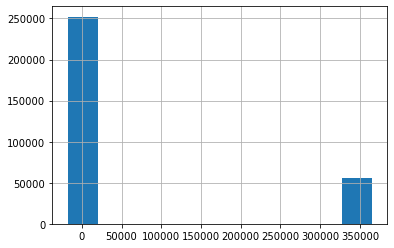

In [115]:
#Plot the DAYS_EMPLOYED variable to see why mean is equivalent to 174.8 years of experience (outliers that don't make sense)
applications["DAYS_EMPLOYED"].hist()

In [116]:
#See how many wrongly inserted values there is and if there is a specific value that is causing it
print(applications[applications["DAYS_EMPLOYED"] > 325000][["DAYS_EMPLOYED"]].value_counts())

#After finding that there is 55374 with valu 365243 days employed, we set them to NaN (to be cleaned in the preprocessing pipeline)
applications["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

DAYS_EMPLOYED
365243           55374
dtype: int64


In [117]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
day_variables = [col for col in applications.columns if 'DAYS' in col]
num_variables = [i for i in num_variables if i not in day_variables]

#### Transformation Pipeline

Create a DataframeSelector Class to be used later on the pipelines

In [118]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, y=None):
        return self
    def transform(self, applications):
        return applications[self.attribute_names].values
    def get_feature_names(self):
        return self.attribute_names

Create a NegativeToPositive Class to be used later on the pipelines

In [119]:
class NegativeToPositive(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, y=None):
        return self
    def transform(self, applications):
        applications[self.attribute_names] = abs(applications[self.attribute_names])
        return applications[self.attribute_names]

Create Pipelines for each type:
- Numerical
- Days
- Categorical
- Categorical Binary

In [120]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ])
day_col_pipeline = Pipeline([
        ('neg_to_pos', NegativeToPositive(day_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])
cat_binary_pipeline = Pipeline ([
        ('imputer', SimpleImputer(strategy="most_frequent"))
        ])

Create Pipeline Preprocessor

In [121]:
preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", day_col_pipeline, day_variables),
        ("cat_pipeline", cat_pipeline, cat_variables),
        ("cat_binary_pipeline", cat_binary_pipeline, cat_binary_variables)
])

Fit pipeline and transform it

In [122]:
preprocess_pipeline.fit(applications)

preprocessed_applications = preprocess_pipeline.transform(applications)

In [123]:
#Get categorical values names after the pipeline preprocessor
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(cat_variables))

#Get all the features names
feature_names = num_variables + day_variables + cat_feature_names + cat_binary_variables

#Print Features names
feature_names  

['CNT_CHILDREN',
 'HOUR_APPR_PROCESS_START',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'NAME_CONTRACT_TYPE_Cash loans',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'CODE_GENDER_F',
 'CODE_GENDER_M',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Group of people',
 'NAME_TYPE_SUITE_Other_A',
 'NAME_TYPE_SUITE_Other_B',
 'NAME_TYPE_SUITE_Spouse, partner',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Commercial associa

Create a new dataframe with the new features after the preprocessor

In [124]:
transformed_applications_df = pd.DataFrame(preprocessed_applications, columns=feature_names)
transformed_applications_df = pd.concat([applications[["SK_ID_CURR", "TARGET"]], transformed_applications_df], axis=1)
transformed_applications_df

,SK_ID_CURR,TARGET,CNT_CHILDREN,HOUR_APPR_PROCESS_START,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,CNT_FAM_MEMBERS,...,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,100002,1,0.0,10.0,202500.0,406597.5,24700.5,351000.0,0.018801,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100003,0,0.0,11.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0.0,9.0,67500.0,135000.0,6750.0,135000.0,0.010032,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,100006,0,0.0,17.0,135000.0,312682.5,29686.5,297000.0,0.008019,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,100007,0,0.0,11.0,121500.0,513000.0,21865.5,513000.0,0.028663,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0.0,15.0,157500.0,254700.0,27558.0,225000.0,0.032561,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0,0.0,8.0,72000.0,269550.0,12001.5,225000.0,0.025164,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
307508,456253,0,0.0,9.0,153000.0,677664.0,29979.0,585000.0,0.005002,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
307509,456254,1,0.0,9.0,171000.0,370107.0,20205.0,319500.0,0.005313,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Rename all the exclusive features that belongs to the Applications Table so later it becomes more clear while performing analysis

In [125]:
transformed_applications_df.columns = ["SK_ID_CURR","TARGET"] + [col + '_APP' for col in transformed_applications_df.columns if col not in ["SK_ID_CURR","TARGET"]]
transformed_applications_df

,SK_ID_CURR,TARGET,CNT_CHILDREN_APP,HOUR_APPR_PROCESS_START_APP,AMT_INCOME_TOTAL_APP,AMT_CREDIT_APP,AMT_ANNUITY_APP,AMT_GOODS_PRICE_APP,REGION_POPULATION_RELATIVE_APP,CNT_FAM_MEMBERS_APP,...,FLAG_DOCUMENT_15_APP,FLAG_DOCUMENT_16_APP,FLAG_DOCUMENT_17_APP,FLAG_DOCUMENT_18_APP,FLAG_DOCUMENT_19_APP,FLAG_DOCUMENT_20_APP,FLAG_DOCUMENT_21_APP,FLAG_OWN_CAR_APP,FLAG_OWN_REALTY_APP,EMERGENCYSTATE_MODE_APP
0,100002,1,0.0,10.0,202500.0,406597.5,24700.5,351000.0,0.018801,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100003,0,0.0,11.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0.0,9.0,67500.0,135000.0,6750.0,135000.0,0.010032,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,100006,0,0.0,17.0,135000.0,312682.5,29686.5,297000.0,0.008019,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,100007,0,0.0,11.0,121500.0,513000.0,21865.5,513000.0,0.028663,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0.0,15.0,157500.0,254700.0,27558.0,225000.0,0.032561,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0,0.0,8.0,72000.0,269550.0,12001.5,225000.0,0.025164,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
307508,456253,0,0.0,9.0,153000.0,677664.0,29979.0,585000.0,0.005002,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
307509,456254,1,0.0,9.0,171000.0,370107.0,20205.0,319500.0,0.005313,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Previous Applications Table


In [126]:
#Path for the file, change it if necessary
prev_app = pd.read_csv("../all/previous_application.csv")

#Values "XNA" (not availables) will be replaced by NaN values
prev_app.replace("XNA", np.nan, inplace=True)

In [127]:
#See if there are any duplicated rows
duplicate_rows = prev_app[prev_app.duplicated()]
len(duplicate_rows)

0

Analyzing missing values


Building a model on variables that have higher than 40% missing values may lead to misleading results since we either have to decrease our sample greatly or substitute the missing values by the median

In [128]:
missing_percentages = prev_app.isna().mean() * 100
feature = missing_percentages.index.tolist() 
percentage = missing_percentages.tolist()

In [129]:
# Find columns with missing values above 40%
columns_to_drop = [feat for feat, perc in zip(feature, percentage) if perc > 40]

# Drop the columns with missing values above 40%
prev_app.drop(columns=columns_to_drop,inplace=True)
prev_app.drop(columns='SELLERPLACE_AREA',inplace=True)

In [130]:
#Print columns to be dropped
print(columns_to_drop)

['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE', 'NAME_TYPE_SUITE', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


Dividing the variables by type to facilitate the EDA and Data Cleaning


In [131]:
variables_type = pd.DataFrame(prev_app.dtypes)

# Get all categorical variables
cat_variables = list(variables_type[variables_type[0] == "object"].index)

# Get all numerical variables that are int
int_variables = list(variables_type[variables_type[0] == "int64"].index)

# Get all numerical variables that are float
float_variables = list(variables_type[variables_type[0] == "float64"].index)

# Get all cateogorical binary variables
cat_binary_variables = []
for i in prev_app:
    if ((list(prev_app[i].unique()) == [0,1]) or (list(prev_app[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR","SK_ID_PREV"]]

#Merge all numerical variables that are float and int
num_variables = int_with_no_binary + float_variables

#Print all variables
print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']
Categorical variables (binary): ['NFLAG_LAST_APPL_IN_DAY']
Numerical variables: ['HOUR_APPR_PROCESS_START', 'DAYS_DECISION', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'CNT_PAYMENT']


### Cleaning all remaining variables

Categorical variables

In [132]:
#Print the unique values of the categorical variables to see if they are correctly categorized
for i in cat_variables:
    print(i, prev_app[i].unique())

NAME_CONTRACT_TYPE ['Consumer loans' 'Cash loans' 'Revolving loans' nan]
WEEKDAY_APPR_PROCESS_START ['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']
FLAG_LAST_APPL_PER_CONTRACT ['Y' 'N']
NAME_CONTRACT_STATUS ['Approved' 'Refused' 'Canceled' 'Unused offer']
NAME_PAYMENT_TYPE ['Cash through the bank' nan 'Non-cash from your account'
 'Cashless from the account of the employer']
CODE_REJECT_REASON ['XAP' 'HC' 'LIMIT' 'CLIENT' 'SCOFR' 'SCO' nan 'VERIF' 'SYSTEM']
NAME_CLIENT_TYPE ['Repeater' 'New' 'Refreshed' nan]
NAME_PORTFOLIO ['POS' 'Cash' nan 'Cards' 'Cars']
CHANNEL_TYPE ['Country-wide' 'Contact center' 'Credit and cash offices' 'Stone'
 'Regional / Local' 'AP+ (Cash loan)' 'Channel of corporate sales'
 'Car dealer']
NAME_YIELD_GROUP ['middle' 'low_action' 'high' 'low_normal' nan]
PRODUCT_COMBINATION ['POS mobile with interest' 'Cash X-Sell: low' 'Cash X-Sell: high'
 'Cash X-Sell: middle' 'Cash Street: high' 'Cash'
 'POS household without interest' 'POS household

In [133]:
#Change binary variables from Yes/No to 1/0
prev_app["FLAG_LAST_APPL_PER_CONTRACT"] = prev_app["FLAG_LAST_APPL_PER_CONTRACT"].apply(lambda x: 0 if x == 'N' else 1)

In [134]:
#Exclude them from cat_variables and include them in cat_binary_variables (useful for the final pipeline)
cat_variables = [i for i in cat_variables if i not in ["FLAG_LAST_APPL_PER_CONTRACT"]]
cat_binary_variables.extend(["FLAG_LAST_APPL_PER_CONTRACT"])

Numerical variables

In [135]:
#Using describe method for numerical variables to get summary statistics and explore the data
prev_app[num_variables].describe()

,HOUR_APPR_PROCESS_START,DAYS_DECISION,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,CNT_PAYMENT
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,1.284699e+06,1.297984e+06
mean,1.248418e+01,-8.806797e+02,1.595512e+04,1.752339e+05,1.961140e+05,2.278473e+05,1.605408e+01
std,3.334028e+00,7.790997e+02,1.478214e+04,2.927798e+05,3.185746e+05,3.153966e+05,1.456729e+01
min,0.000000e+00,-2.922000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+01,-1.300000e+03,6.321780e+03,1.872000e+04,2.416050e+04,5.084100e+04,6.000000e+00
50%,1.200000e+01,-5.810000e+02,1.125000e+04,7.104600e+04,8.054100e+04,1.123200e+05,1.200000e+01
75%,1.500000e+01,-2.800000e+02,2.065842e+04,1.803600e+05,2.164185e+05,2.340000e+05,2.400000e+01
max,2.300000e+01,-1.000000e+00,4.180581e+05,6.905160e+06,6.905160e+06,6.905160e+06,8.400000e+01


Findings:


* DAYS_DECISION variables are counter-intuitively negative

In [136]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
day_variables = [col for col in prev_app.columns if 'DAYS_DECISION' in col]
num_variables = [i for i in num_variables if i not in day_variables]

### Pipeline

Create a DataframeSelector Class to be used later on the pipelines

In [137]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, y=None):
        return self
    def transform(self, prev_app):
        return prev_app[self.attribute_names].values
    def get_feature_names(self):
        return self.attribute_names

Create a NegativeToPositive Class to be used later on the pipelines

In [138]:
class NegativeToPositive(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, prev_app, y=None):
        return self
    def transform(self, pre_app):
        prev_app[self.attribute_names] = abs(prev_app[self.attribute_names])
        return prev_app[self.attribute_names]

Create Pipelines for each type:
- Numerical
- Days
- Categorical
- Categorical Binary

In [139]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median"))
        ])
day_col_pipeline = Pipeline([
        ('neg_to_pos', NegativeToPositive(day_variables)),
        ('imputer', SimpleImputer(strategy="median"))
        ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])
cat_binary_pipeline = Pipeline ([
        ('imputer', SimpleImputer(strategy="most_frequent"))
        ])

Create pipeline preprocessors

In [140]:
preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", day_col_pipeline, day_variables),
        ("cat_pipeline", cat_pipeline, cat_variables),
        ("cat_binary_pipeline", cat_binary_pipeline, cat_binary_variables)
])

Fit and transform the pipeline

In [141]:
preprocess_pipeline.fit_transform(prev_app)
preprocessed_prev_app = preprocess_pipeline.transform(prev_app)

In [142]:
#Get categorical values names after the pipeline preprocessor
cat_feature_names = preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(cat_variables)

#Get all the features names
feature_names = list(num_variables) + list(day_variables) + list(cat_feature_names) + list(cat_binary_variables)

In [143]:
dense_matrix = preprocessed_prev_app.todense()

Create a new dataframe with all the data preprocessed 

In [144]:
transformed_prev_app_df = pd.DataFrame(dense_matrix, columns=feature_names)
transformed_prev_app_df = pd.concat([prev_app[["SK_ID_CURR", "SK_ID_PREV"]],transformed_prev_app_df], axis=1)
transformed_prev_app_df

,SK_ID_CURR,SK_ID_PREV,HOUR_APPR_PROCESS_START,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,CNT_PAYMENT,DAYS_DECISION,NAME_CONTRACT_TYPE_Cash loans,...,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NFLAG_LAST_APPL_IN_DAY,FLAG_LAST_APPL_PER_CONTRACT
0,271877,2030495,15.0,1730.430,17145.0,17145.0,17145.0,12.0,73.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,108129,2802425,11.0,25188.615,607500.0,679671.0,607500.0,36.0,164.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,122040,2523466,11.0,15060.735,112500.0,136444.5,112500.0,12.0,301.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,176158,2819243,7.0,47041.335,450000.0,470790.0,450000.0,12.0,512.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,202054,1784265,9.0,31924.395,337500.0,404055.0,337500.0,24.0,781.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,352015,2300464,12.0,14704.290,267295.5,311400.0,267295.5,30.0,544.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1670210,334635,2357031,15.0,6622.020,87750.0,64291.5,87750.0,12.0,1694.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1670211,249544,2659632,12.0,11520.855,105237.0,102523.5,105237.0,10.0,1488.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1670212,400317,2785582,9.0,18821.520,180000.0,191880.0,180000.0,12.0,1185.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


Create aggregation functions to be used on the groupby

In [145]:
aggregation_functions = {}

aggregation_functions['SK_ID_PREV'] = 'count'
aggregation_functions['HOUR_APPR_PROCESS_START'] = 'mean'
aggregation_functions['DAYS_DECISION'] = 'mean' 
aggregation_functions['CNT_PAYMENT'] = 'mean'

for col in transformed_prev_app_df.columns:
    if col.startswith('AMT'):
        aggregation_functions[col] = 'mean'

    if (col in cat_feature_names) | (col in cat_binary_variables):
        aggregation_functions[col] = 'sum'

Perform groupby

In [146]:
prev_applications = transformed_prev_app_df.groupby('SK_ID_CURR').agg(aggregation_functions)
prev_applications.reset_index(inplace=True)

In [147]:
prev_applications.rename(columns={'SK_ID_PREV': 'COUNT_PREV'},inplace=True)
prev_applications

,SK_ID_CURR,COUNT_PREV,HOUR_APPR_PROCESS_START,DAYS_DECISION,CNT_PAYMENT,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE_Cash loans,...,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NFLAG_LAST_APPL_IN_DAY,FLAG_LAST_APPL_PER_CONTRACT
0,100001,1,13.000000,1740.000,8.00,3951.000000,24835.500,23787.00,24835.500,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,100002,1,9.000000,606.000,24.00,9251.775000,179055.000,179055.00,179055.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,100003,3,14.666667,1305.000,10.00,56553.990000,435436.500,484191.00,435436.500,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
3,100004,1,5.000000,815.000,4.00,5357.250000,24282.000,20106.00,24282.000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,100005,2,10.500000,536.000,12.00,8031.600000,22308.750,20076.75,78468.750,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1,17.000000,273.000,8.00,6605.910000,40455.000,40455.00,40455.000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
338853,456252,1,10.000000,2497.000,6.00,10074.465000,57595.500,56821.50,57595.500,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
338854,456253,2,11.500000,2380.000,5.00,4770.405000,24162.750,20625.75,24162.750,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0
338855,456254,2,15.000000,299.500,15.00,10681.132500,121317.750,134439.75,121317.750,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0


Rename all the exclusive features that belongs to the Previous Applications Table so later it becomes more clear while performing analysis

In [148]:
prev_applications.columns = ["SK_ID_CURR"] + [col + '_PA' for col in prev_applications.columns if col not in ["SK_ID_CURR"]]
prev_applications

,SK_ID_CURR,COUNT_PREV_PA,HOUR_APPR_PROCESS_START_PA,DAYS_DECISION_PA,CNT_PAYMENT_PA,AMT_ANNUITY_PA,AMT_APPLICATION_PA,AMT_CREDIT_PA,AMT_GOODS_PRICE_PA,NAME_CONTRACT_TYPE_Cash loans_PA,...,PRODUCT_COMBINATION_POS household with interest_PA,PRODUCT_COMBINATION_POS household without interest_PA,PRODUCT_COMBINATION_POS industry with interest_PA,PRODUCT_COMBINATION_POS industry without interest_PA,PRODUCT_COMBINATION_POS mobile with interest_PA,PRODUCT_COMBINATION_POS mobile without interest_PA,PRODUCT_COMBINATION_POS other with interest_PA,PRODUCT_COMBINATION_POS others without interest_PA,NFLAG_LAST_APPL_IN_DAY_PA,FLAG_LAST_APPL_PER_CONTRACT_PA
0,100001,1,13.000000,1740.000,8.00,3951.000000,24835.500,23787.00,24835.500,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,100002,1,9.000000,606.000,24.00,9251.775000,179055.000,179055.00,179055.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,100003,3,14.666667,1305.000,10.00,56553.990000,435436.500,484191.00,435436.500,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
3,100004,1,5.000000,815.000,4.00,5357.250000,24282.000,20106.00,24282.000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,100005,2,10.500000,536.000,12.00,8031.600000,22308.750,20076.75,78468.750,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1,17.000000,273.000,8.00,6605.910000,40455.000,40455.00,40455.000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
338853,456252,1,10.000000,2497.000,6.00,10074.465000,57595.500,56821.50,57595.500,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
338854,456253,2,11.500000,2380.000,5.00,4770.405000,24162.750,20625.75,24162.750,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0
338855,456254,2,15.000000,299.500,15.00,10681.132500,121317.750,134439.75,121317.750,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0


## Credit card balance

- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.

- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

CUSTOMER RISK PROFILE

- Number of Loans per Customer
- Rate at which Loan is paid back by customer - No of instalments per customer per loan
- How much did the Customer load a Credit line?
- How many times did the Customer miss the minimum payment?
- What is the average number of days did Customer go past due date?
- What fraction of minimum payments were missed?

CUSTOMER BEHAVIOUR PATTERNS

- Cash withdrawals VS Overall Spending ratio
- Average number of drawings per customer - Total Drawings / Number of Drawings

In [149]:
# Load data

credit_card_balance = pd.read_csv('../all/credit_card_balance.csv', sep=',')

credit_card_balance.head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.500,0.0,877.500,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.000,0.0,0.000,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.000,0.0,0.000,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.000,0.0,0.000,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.000,0.0,11547.000,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.815,270000,0.0,0.000,0.0,0.000,4449.105,...,82773.315,82773.315,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.645,585000,67500.0,67500.000,0.0,0.000,14684.175,...,351881.145,351881.145,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125,45000,45000.0,45000.000,0.0,0.000,0.000,...,47962.125,47962.125,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.075,292500,90000.0,289339.425,0.0,199339.425,130.500,...,286831.575,286831.575,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.195,225000,76500.0,111026.700,0.0,34526.700,6338.340,...,197224.695,197224.695,3.0,9,0.0,6.0,38.0,Active,0,0


In [150]:
# Identify duplicate rows

duplicate_rows = credit_card_balance[credit_card_balance.duplicated()]
len(duplicate_rows)

0

### Feature selection

In [151]:
# Feature selection

credit_card_balance.loc[0:10, ["SK_ID_PREV", "SK_ID_CURR", "AMT_PAYMENT_CURRENT", "AMT_PAYMENT_TOTAL_CURRENT"]]

,SK_ID_PREV,SK_ID_CURR,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT
0,2562384,378907,1800.000,1800.000
1,2582071,363914,2250.000,2250.000
2,1740877,371185,2250.000,2250.000
3,1389973,337855,11925.000,11925.000
4,1891521,126868,27000.000,27000.000
5,2646502,380010,3825.000,3825.000
6,1079071,171320,15750.000,15750.000
7,2095912,118650,264.690,0.000
8,2181852,367360,4093.515,4093.515
9,1235299,203885,45000.000,45000.000


In [152]:
credit_card_balance.loc[credit_card_balance["AMT_PAYMENT_CURRENT"] < credit_card_balance["AMT_PAYMENT_TOTAL_CURRENT"],
                        :].loc[:, ["AMT_PAYMENT_CURRENT", "AMT_PAYMENT_TOTAL_CURRENT"]]

,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT


AMT_PAYMENT_CURRENT is never lower than AMT_PAYMENT_TOTAL_CURRENT (it is always higher or equal, or they are both null), which means that AMT_PAYMENT_CURRENT contains the value in AMT_PAYMENT_TOTAL_CURRENT. Therefore, we can drop that column.

In [153]:
credit_card_balance.loc[credit_card_balance["AMT_DRAWINGS_CURRENT"] < credit_card_balance["AMT_DRAWINGS_ATM_CURRENT"], :].loc[:, ["AMT_DRAWINGS_CURRENT",
                                                                                                                                  "AMT_DRAWINGS_ATM_CURRENT"]]

,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_ATM_CURRENT
438776,-1687.50,0.0
747302,-519.57,0.0
3284667,-6211.62,0.0


Same thing for AMT_DRAWINGS_CURRENT and AMT_DRAWINGS_ATM_CURRENT. Even though the amount of drawings in the ATM may be zero, the amount of drawings in total can be negative - when the amount of money drawing during a month by a client is lower than zero, it means that the client has made a payment to the bank that is greater than the outstanding balance on their credit card.

Therefore, we can drop AMT_DRAWINGS_ATM_CURRENT, because AMT_DRAWINGS_CURRENT contains all the information. Same thing applies to AMT_DRAWINGS_POS_CURRENT. 

In [154]:
credit_card_balance.loc[0:10, ["AMT_DRAWINGS_CURRENT", "AMT_DRAWINGS_OTHER_CURRENT"]]

,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT
0,877.500,0.0
1,2250.000,0.0
2,0.000,0.0
3,2250.000,0.0
4,11547.000,0.0
5,0.000,0.0
6,67500.000,0.0
7,45000.000,0.0
8,289339.425,0.0
9,111026.700,0.0


In [155]:
credit_card_balance.loc[credit_card_balance["AMT_DRAWINGS_CURRENT"] < credit_card_balance["AMT_DRAWINGS_OTHER_CURRENT"], :].loc[:, ["AMT_DRAWINGS_CURRENT", "AMT_DRAWINGS_OTHER_CURRENT"]]

,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT
438776,-1687.50,0.0
747302,-519.57,0.0
3284667,-6211.62,0.0


We can also drop this column.

Regarding AMT_RECEIVABLE_PRINCIPAL, AMT_RECIVABLE and AMT_TOTAL_RECEIVABLE, since AMT_TOTAL_RECEIVABLE is the total amount receivable on the previous credit, that contains the number we need and we can drop the other two columns.

Considering the columns we decided to drop, regarding the 4 columns with the number of drawings in the month in matter, it only makes sense to keep CNT_DRAWINGS_CURRENT, because that's what we can connect to the information that wasn't dropped. Also, that column contains total number of drawings, while the other 3 contained very specific drawings.

In [156]:
# Drop the columns

credit_card_balance.drop(['AMT_PAYMENT_TOTAL_CURRENT', 'AMT_DRAWINGS_ATM_CURRENT',
                          'AMT_DRAWINGS_POS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
                          "AMT_RECEIVABLE_PRINCIPAL", "AMT_RECIVABLE",
                          "CNT_DRAWINGS_ATM_CURRENT", "CNT_DRAWINGS_OTHER_CURRENT",
                          "CNT_DRAWINGS_POS_CURRENT", "AMT_INST_MIN_REGULARITY", 
                         "SK_DPD", "SK_DPD_DEF"],
                         axis=1, inplace=True)

In [157]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_PAYMENT_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS
0,2562384,378907,-6,56.970,135000,877.5,1800.00,0.000,1,35.0,Active
1,2582071,363914,-1,63975.555,45000,2250.0,2250.00,64875.555,1,69.0,Active
2,1740877,371185,-7,31815.225,450000,0.0,2250.00,31460.085,0,30.0,Active
3,1389973,337855,-4,236572.110,225000,2250.0,11925.00,233048.970,1,10.0,Active
4,1891521,126868,-1,453919.455,450000,11547.0,27000.00,453919.455,1,101.0,Active
...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,0.0,NaN,0.000,0,0.0,Active
3840308,1714892,347207,-9,0.000,45000,0.0,1879.11,0.000,0,23.0,Active
3840309,1302323,215757,-9,275784.975,585000,270000.0,375750.00,273093.975,2,18.0,Active
3840310,1624872,430337,-10,0.000,450000,0.0,NaN,0.000,0,0.0,Active


### Dealing with missing values

In [158]:
# Deal with missing values

n_null_dict = {}

for column in credit_card_balance.columns:
    null_sum = credit_card_balance.isnull()[column].sum()
    n_null_dict[column] = null_sum

n_null = pd.DataFrame(n_null_dict, index = ["Number of missing values"])

In [159]:
n_null

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_PAYMENT_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS
Number of missing values,0,0,0,0,0,0,767988,0,0,305236,0


### Final pipeline to transform data and get new dataframe:

In [160]:
num_variables = [col for col in credit_card_balance.columns if col != 'NAME_CONTRACT_STATUS' and col != 'SK_ID_PREV' and col != 'SK_ID_CURR']

cat_variables = ["NAME_CONTRACT_STATUS"]

Create Pipelines for each type:
- Numerical
- Categorical

In [161]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

Create pipeline preprocessor

In [162]:
preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("cat_pipeline", cat_pipeline, cat_variables)
])

Fit and transform the pipeline

In [163]:
preprocess_pipeline.fit(credit_card_balance)

preprocessed_credit_card_balance = preprocess_pipeline.transform(credit_card_balance)

In [164]:
#Get the new categorical features names after the pipeline
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(cat_variables))

#Get all the new features names
feature_names = num_variables + cat_feature_names
feature_names

['MONTHS_BALANCE',
 'AMT_BALANCE',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_DRAWINGS_CURRENT',
 'AMT_PAYMENT_CURRENT',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'NAME_CONTRACT_STATUS_Active',
 'NAME_CONTRACT_STATUS_Approved',
 'NAME_CONTRACT_STATUS_Completed',
 'NAME_CONTRACT_STATUS_Demand',
 'NAME_CONTRACT_STATUS_Refused',
 'NAME_CONTRACT_STATUS_Sent proposal',
 'NAME_CONTRACT_STATUS_Signed']

Create a new dataframe with the data after being processed by the pipeline

In [165]:
transformed_credit_card_balance_df = pd.DataFrame(preprocessed_credit_card_balance, columns=feature_names)
transformed_credit_card_balance_df = pd.concat([credit_card_balance[["SK_ID_CURR", 'SK_ID_PREV']],transformed_credit_card_balance_df], axis=1)
transformed_credit_card_balance_df

,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_PAYMENT_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Sent proposal,NAME_CONTRACT_STATUS_Signed
0,378907,2562384,-6.0,56.970,135000.0,877.5,1800.00,0.000,1.0,35.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,363914,2582071,-1.0,63975.555,45000.0,2250.0,2250.00,64875.555,1.0,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,371185,1740877,-7.0,31815.225,450000.0,0.0,2250.00,31460.085,0.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,337855,1389973,-4.0,236572.110,225000.0,2250.0,11925.00,233048.970,1.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,126868,1891521,-1.0,453919.455,450000.0,11547.0,27000.00,453919.455,1.0,101.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,328243,1036507,-9.0,0.000,45000.0,0.0,2702.70,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3840308,347207,1714892,-9.0,0.000,45000.0,0.0,1879.11,0.000,0.0,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3840309,215757,1302323,-9.0,275784.975,585000.0,270000.0,375750.00,273093.975,2.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3840310,430337,1624872,-10.0,0.000,450000.0,0.0,2702.70,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Transforming dataset into dataset with one row per client 

In [166]:
credit_card_balance_grouped = transformed_credit_card_balance_df.groupby(["SK_ID_CURR", "SK_ID_PREV"]).agg({
    'AMT_BALANCE': 'mean',
    'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
    'AMT_DRAWINGS_CURRENT': 'mean',
    'AMT_PAYMENT_CURRENT': 'mean',
    'AMT_TOTAL_RECEIVABLE': 'mean',
    'CNT_DRAWINGS_CURRENT': 'mean',
    'CNT_INSTALMENT_MATURE_CUM': 'mean',
    'NAME_CONTRACT_STATUS_Active': 'max',
    'NAME_CONTRACT_STATUS_Approved': 'max',
    'NAME_CONTRACT_STATUS_Completed': 'max',
    'NAME_CONTRACT_STATUS_Demand': 'max',
    'NAME_CONTRACT_STATUS_Refused': 'max',
    'NAME_CONTRACT_STATUS_Sent proposal': 'max',
    'NAME_CONTRACT_STATUS_Signed': 'max'
}).reset_index()

credit_card_balance_grouped = credit_card_balance_grouped.groupby("SK_ID_CURR").agg({
    "SK_ID_PREV": "count",
    'AMT_BALANCE': 'mean',
    'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
    'AMT_DRAWINGS_CURRENT': 'mean',
    'AMT_PAYMENT_CURRENT': 'mean',
    'AMT_TOTAL_RECEIVABLE': 'mean',
    'CNT_DRAWINGS_CURRENT': 'mean',
    'CNT_INSTALMENT_MATURE_CUM': 'mean',
    'NAME_CONTRACT_STATUS_Active': 'sum',
    'NAME_CONTRACT_STATUS_Approved': 'sum',
    'NAME_CONTRACT_STATUS_Completed': 'sum',
    'NAME_CONTRACT_STATUS_Demand': 'sum',
    'NAME_CONTRACT_STATUS_Refused': 'sum',
    'NAME_CONTRACT_STATUS_Sent proposal': 'sum',
    'NAME_CONTRACT_STATUS_Signed': 'sum'
}).reset_index()

In [167]:
credit_card_balance_grouped = credit_card_balance_grouped.rename(columns={'SK_ID_PREV': 'COUNT_PREV'})

credit_card_balance_grouped

,SK_ID_CURR,COUNT_PREV,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_PAYMENT_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Sent proposal,NAME_CONTRACT_STATUS_Signed
0,100006,1,0.000000,270000.000000,0.000000,2702.700000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100011,1,54482.111149,164189.189189,2432.432432,4843.064189,54433.179122,0.054054,25.621622,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,1,18159.919219,131718.750000,5953.125000,7168.346250,18101.079844,0.239583,18.447917,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100021,1,0.000000,675000.000000,0.000000,2702.700000,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,100023,1,0.000000,135000.000000,0.000000,2702.700000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103553,456244,1,131834.730732,296341.463415,26842.388049,32720.544878,130767.060732,1.365854,13.634146,1.0,0.0,1.0,0.0,0.0,0.0,0.0
103554,456246,1,13136.731875,135000.000000,15199.256250,16768.828125,12897.894375,2.500000,3.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
103555,456247,1,23216.396211,144000.000000,2149.506474,4883.755263,23128.243105,0.147368,26.494737,1.0,0.0,0.0,0.0,0.0,0.0,0.0
103556,456248,1,0.000000,900000.000000,0.000000,2702.700000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Rename all the exclusive features that belongs to the Credit Card Table so later it becomes more clear while performing analysis

In [168]:
credit_card_balance_grouped.columns = ["SK_ID_CURR"] + [col + '_CCB' for col in credit_card_balance_grouped.columns if col not in ["SK_ID_CURR"]]
credit_card_balance_grouped

,SK_ID_CURR,COUNT_PREV_CCB,AMT_BALANCE_CCB,AMT_CREDIT_LIMIT_ACTUAL_CCB,AMT_DRAWINGS_CURRENT_CCB,AMT_PAYMENT_CURRENT_CCB,AMT_TOTAL_RECEIVABLE_CCB,CNT_DRAWINGS_CURRENT_CCB,CNT_INSTALMENT_MATURE_CUM_CCB,NAME_CONTRACT_STATUS_Active_CCB,NAME_CONTRACT_STATUS_Approved_CCB,NAME_CONTRACT_STATUS_Completed_CCB,NAME_CONTRACT_STATUS_Demand_CCB,NAME_CONTRACT_STATUS_Refused_CCB,NAME_CONTRACT_STATUS_Sent proposal_CCB,NAME_CONTRACT_STATUS_Signed_CCB
0,100006,1,0.000000,270000.000000,0.000000,2702.700000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100011,1,54482.111149,164189.189189,2432.432432,4843.064189,54433.179122,0.054054,25.621622,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,1,18159.919219,131718.750000,5953.125000,7168.346250,18101.079844,0.239583,18.447917,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100021,1,0.000000,675000.000000,0.000000,2702.700000,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,100023,1,0.000000,135000.000000,0.000000,2702.700000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103553,456244,1,131834.730732,296341.463415,26842.388049,32720.544878,130767.060732,1.365854,13.634146,1.0,0.0,1.0,0.0,0.0,0.0,0.0
103554,456246,1,13136.731875,135000.000000,15199.256250,16768.828125,12897.894375,2.500000,3.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
103555,456247,1,23216.396211,144000.000000,2149.506474,4883.755263,23128.243105,0.147368,26.494737,1.0,0.0,0.0,0.0,0.0,0.0,0.0
103556,456248,1,0.000000,900000.000000,0.000000,2702.700000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Installment payments



In [169]:
# Load data
installment_payments = pd.read_csv('../all/installments_payments.csv', sep=',')

installment_payments.head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375
6,2234264,184693,4.0,11,-349.0,-352.0,29432.295,29432.295
7,1818599,111420,2.0,4,-968.0,-994.0,17862.165,17862.165
8,2723183,112102,0.0,14,-197.0,-197.0,70.740,70.740
9,1413990,109741,1.0,4,-570.0,-609.0,14308.470,14308.470


In [170]:
# Identify duplicate rows

duplicate_rows = installment_payments[installment_payments.duplicated()]
len(duplicate_rows)

0

### Dealing with missing values

Delete all columns that contain a percentage of missing values higher than 40%

In [171]:
#List with features that has missing values lower than 40%
miss_lower40 = []
#List with features that has missing values higher than 40%
miss_higher40 = []

for i in installment_payments:
    pct_missing = (installment_payments[i].isna().sum()/len(installment_payments[i]))*100
    if pct_missing > 0 and pct_missing < 40:
        miss_lower40.append(i)
    if pct_missing >= 40:
        miss_higher40.append(i)

In [172]:
print("Missing percentage lower than 40:", miss_lower40)
print("Missing percentage higher than 40:", miss_higher40)

Missing percentage lower than 40: ['DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT']
Missing percentage higher than 40: []


We only have missing values in the collumns:

- DAYS_ENTRY_PAYMENT, which says when was the installments of previous credit paid actually (relative to application date of current loan)
- AMT_PAYMENT, what the client actually paid on previous credit on this installment

Let's replace the null values in DAYS_ENTRY_PAYMENT with "0" so that when we calculate a new column with the delay in payment, we get the delay we have relative to application date, even though the client can take even more time to make the payment.

However, we will create a new column saying whether the client has already payed previous installment or not, to identify these cases.

For the column AMT_PAYMENT, we will replace null values with 0 (because they haven't payed yet.

**How will we analyze data**: For the cases where client has payed, check values of delay time and difference between amount of installment and amount payed. Cases where client hasn't payed yet, take only into consideration that he hasn't payed yet.

### Feature selection and new columns

DAYS_INSTALMENT columns says when the installment of previous credit was supposed to be paid, and DAYS_ENTRY_PAYMENT says when was the installments of previous credit paid actually. We'll drop those two columns and replace them with one with the difference between both. That new column will show the delay in the installment payment.

### Pipeline

Create DataFrameSelector class to be used in the pipeline

In [173]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Create NegativeToPositive class to be used in the pipeline

In [174]:
class NegativeToPositive(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, y=None):
        return self
    def transform(self, installment_payments):
        installment_payments[self.attribute_names] = abs(installment_payments[self.attribute_names])
        return installment_payments[self.attribute_names]

Define a function to add features

In [175]:
def add_features(X):
    DAYS_PAYMENT_DELAY = X[:, DAYS_ENTRY_PAYMENT] - X[:, DAYS_INSTALMENT]
    AMT_MISSING_PAYMENT = X[:, AMT_INSTALMENT] - X[:, AMT_PAYMENT]
    INSTALLMENT_PAYED = [0 if i == 0 else 1 for i in X[:, DAYS_ENTRY_PAYMENT]]
    return np.c_[DAYS_PAYMENT_DELAY, AMT_MISSING_PAYMENT, INSTALLMENT_PAYED]

Create a pipeline, fit it and transform it

In [176]:
features_1 = ['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']

DAYS_ENTRY_PAYMENT, DAYS_INSTALMENT, AMT_INSTALMENT, AMT_PAYMENT = [
    list(features_1).index(col)
    for col in ('DAYS_ENTRY_PAYMENT', 'DAYS_INSTALMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT')]

features1_pipeline = Pipeline([('neg_to_pos', NegativeToPositive(features_1)),
                                ('imputer', SimpleImputer(strategy="constant", fill_value=0)),
                                ('add_features', FunctionTransformer(add_features, validate=False))
                                 ])

preprocessor = ColumnTransformer([('features1_pipeline', features1_pipeline, features_1)])

preprocessor.fit(installment_payments)

process_installment_payments = preprocessor.transform(installment_payments)

In [177]:
new_installment_payments = pd.concat([installment_payments[["SK_ID_CURR","SK_ID_PREV"]], 
                                      pd.DataFrame(process_installment_payments, 
                                                   columns=["DAYS_PAYMENT_DELAY", "AMT_MISSING_PAYMENT", "INSTALLMENT_PAYED"])],
                                    axis=1
                                    )
new_installment_payments

,SK_ID_CURR,SK_ID_PREV,DAYS_PAYMENT_DELAY,AMT_MISSING_PAYMENT,INSTALLMENT_PAYED
0,161674,1054186,7.0,0.000,1.0
1,151639,1330831,0.0,0.000,1.0
2,193053,2085231,0.0,0.000,1.0
3,199697,2452527,8.0,0.000,1.0
4,167756,2714724,-17.0,4.455,1.0
...,...,...,...,...,...
13605396,428057,2186857,-1624.0,67.500,0.0
13605397,414406,1310347,-1539.0,67.500,0.0
13605398,402199,1308766,-7.0,43737.435,0.0
13605399,409297,1062206,-1986.0,67.500,0.0


Perform a groupby by the SK_ID_CURR

In [178]:
grouped_installment_payments = new_installment_payments.groupby("SK_ID_CURR").agg(
    {'SK_ID_PREV': 'count',
     'DAYS_PAYMENT_DELAY': 'mean',
     'AMT_MISSING_PAYMENT': 'sum',
     'INSTALLMENT_PAYED': 'sum'}
).reset_index()

grouped_installment_payments.rename(columns = {'SK_ID_PREV':'COUNT_PREV'}, inplace=True)

grouped_installment_payments

,SK_ID_CURR,COUNT_PREV,DAYS_PAYMENT_DELAY,AMT_MISSING_PAYMENT,INSTALLMENT_PAYED
0,100001,7,7.285714,0.000,7.0
1,100002,19,20.421053,0.000,19.0
2,100003,25,7.160000,0.000,25.0
3,100004,3,7.666667,0.000,3.0
4,100005,9,23.555556,0.000,9.0
...,...,...,...,...,...
339582,456251,7,36.285714,0.000,7.0
339583,456252,6,2.833333,0.000,6.0
339584,456253,14,14.500000,3973.095,14.0
339585,456254,19,19.000000,0.000,19.0


Rename all the exclusive features that belongs to the Installment Payments Table so later it becomes more clear while performing analysis

In [179]:
grouped_installment_payments.columns = ["SK_ID_CURR"] + [col + '_IP' for col in grouped_installment_payments.columns if col not in ["SK_ID_CURR"]]
grouped_installment_payments

,SK_ID_CURR,COUNT_PREV_IP,DAYS_PAYMENT_DELAY_IP,AMT_MISSING_PAYMENT_IP,INSTALLMENT_PAYED_IP
0,100001,7,7.285714,0.000,7.0
1,100002,19,20.421053,0.000,19.0
2,100003,25,7.160000,0.000,25.0
3,100004,3,7.666667,0.000,3.0
4,100005,9,23.555556,0.000,9.0
...,...,...,...,...,...
339582,456251,7,36.285714,0.000,7.0
339583,456252,6,2.833333,0.000,6.0
339584,456253,14,14.500000,3973.095,14.0
339585,456254,19,19.000000,0.000,19.0


## Bureau

### Bureau Balance

Monthly balances of previous credits in Credit Bureau.

In [180]:
bureau_balance = pd.read_csv('../all/bureau_balance.csv')

In [181]:
bureau_balance.shape

(27299925, 3)

number of rows = # loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits

In [182]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Split the variables into:
- Categorical
- Numerical
- Categorical Binary

In [183]:
variables_type = pd.DataFrame(bureau_balance.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in bureau_balance:
    if ((list(bureau_balance[i].unique()) == [0,1]) or (list(bureau_balance[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_BUREAU"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['STATUS']
Categorical variables (binary): []
Numerical variables: ['MONTHS_BALANCE']


In [184]:
for column in cat_variables:
    print(column)
    print(bureau_balance[column].unique())

STATUS
['C' '0' 'X' '1' '2' '3' '5' '4']


* C - closed
* X - status unknown
* 0 - no DPD
* 1 - maximal did during month between 1-30
* 2 - DPD 31-60
* 5 - DPD 120+ or sold or written off

In [185]:
#replace x for NaN
bureau_balance['STATUS'] = bureau_balance['STATUS'].replace('X', np.nan)

**Duplicates**

In [186]:
#check duplicates
duplicate_rows = bureau_balance[bureau_balance.duplicated()]
print('Number of duplicate rows:', len(duplicate_rows))

Number of duplicate rows: 0


**Missing Values**

In [187]:
#List the variables with missing values higher or equal to 40% to exclude these variables later on
#List the variables with missing values higher than 0% and lower than 40% to preprocess them later on
miss_lower40 = []
miss_higher40 = []

for i in bureau_balance:
    pct_missing = (bureau_balance[i].isna().sum()/len(bureau_balance[i]))*100
    if pct_missing > 0 and pct_missing < 40:
        miss_lower40.append(i)
    if pct_missing >= 40:
        miss_higher40.append(i)

In [188]:
#Exclude the variables with missing values higher or equal to 40%
if (len(miss_lower40) != 0) | (len(miss_higher40) != 0):
    cat_variables = [i for i in cat_variables if i not in miss_higher40]
    num_variables = [i for i in num_variables if i not in miss_higher40]

**Statistics**

In [189]:
bureau_balance[num_variables].describe()

,MONTHS_BALANCE
count,2.729992e+07
mean,-3.074169e+01
std,2.386451e+01
min,-9.600000e+01
25%,-4.600000e+01
50%,-2.500000e+01
75%,-1.100000e+01
max,0.000000e+00


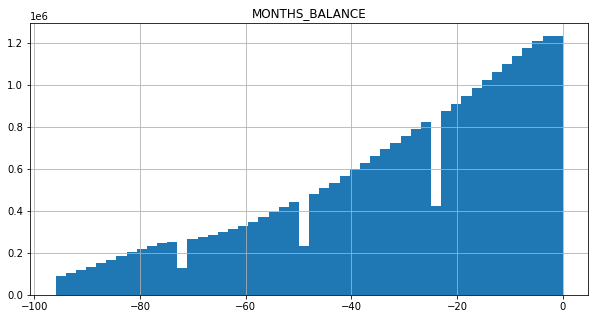

In [190]:
bureau_balance[num_variables].hist(bins=50, figsize=(10,5))
plt.show()

Month of balance relative to application date (-1 means the freshest balance date)

Findings:

* MONTHS_BALANCE variable is counter-intuitively negative 

#### Pipeline

Create a DataFrameSelector Class to be used later on pipeline

In [191]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, y=None):
        return self
    
    def transform(self, bureau_balance):
        return bureau_balance[self.attribute_names].values
    
    def get_feature_names(self):
        return self.attribute_names

Create the pipeline and the preprocessors

In [192]:
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

preprocess_pipeline = ColumnTransformer([
        ("cat_pipeline", cat_pipeline, cat_variables)
])

Fit and transform the pipeline

In [193]:
preprocess_pipeline.fit(bureau_balance)

preprocessed_bureau_balance = preprocess_pipeline.transform(bureau_balance)

In [194]:
#Get the name of the new categorical features
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(cat_variables))

#Store the name of all features after the pipeline
feature_names = cat_feature_names + cat_binary_variables

Create a new dataframe with the new features after the pipeline

In [195]:
dense_matrix_bureau_balance = preprocessed_bureau_balance.todense()

preprocessed_bureau_balance_df = pd.DataFrame(dense_matrix_bureau_balance, columns=feature_names)
transformed_bureau_balance_df = pd.concat([bureau_balance["SK_ID_BUREAU"], preprocessed_bureau_balance_df], axis=1)
transformed_bureau_balance_df

,SK_ID_BUREAU,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C
0,5715448,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5715448,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5715448,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5715448,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5715448,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
27299920,5041336,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27299921,5041336,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27299922,5041336,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27299923,5041336,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Perform a groupby bu the SK_ID_BUREAU

In [196]:
bureau_balance = transformed_bureau_balance_df.groupby("SK_ID_BUREAU").sum().reset_index()
bureau_balance

,SK_ID_BUREAU,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C
0,5001709,0.0,0.0,0.0,0.0,0.0,0.0,97.0
1,5001710,5.0,0.0,0.0,0.0,0.0,0.0,78.0
2,5001711,3.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5001712,10.0,0.0,0.0,0.0,0.0,0.0,9.0
4,5001713,0.0,0.0,0.0,0.0,0.0,0.0,22.0
...,...,...,...,...,...,...,...,...
817390,6842884,9.0,0.0,0.0,0.0,0.0,0.0,39.0
817391,6842885,12.0,0.0,0.0,0.0,0.0,12.0,0.0
817392,6842886,8.0,0.0,0.0,0.0,0.0,0.0,25.0
817393,6842887,6.0,0.0,0.0,0.0,0.0,0.0,31.0


### Bureau

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

In [197]:
bureau = pd.read_csv('../all/bureau.csv')

In [198]:
bureau.shape

(1716428, 17)

In [199]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [200]:
#number of unique SK_ID_CURR
len(bureau['SK_ID_CURR'].unique())

305811

In [201]:
bureau.groupby(['SK_ID_CURR'])['SK_ID_CURR'].count().sort_values(ascending=False)

SK_ID_CURR
120860    116
169704     94
318065     78
251643     61
425396     60
         ... 
243209      1
397571      1
192555      1
325740      1
154408      1
Name: SK_ID_CURR, Length: 305811, dtype: int64

Split the variables into:
- Categorical
- Numerical
- Categorical Binary

In [202]:
variables_type = pd.DataFrame(bureau.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in bureau:
    if ((list(bureau[i].unique()) == [0,1]) or (list(bureau[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "SK_ID_BUREAU"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
Categorical variables (binary): []
Numerical variables: ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY']


In [203]:
for column in cat_variables:
    print(column)
    print(bureau[column].unique())
    print('--------------------------')

CREDIT_ACTIVE
['Closed' 'Active' 'Sold' 'Bad debt']
--------------------------
CREDIT_CURRENCY
['currency 1' 'currency 2' 'currency 4' 'currency 3']
--------------------------
CREDIT_TYPE
['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']
--------------------------


**Duplicates**

In [204]:
#check duplicates
duplicate_rows = bureau[bureau.duplicated()]
print('Number of duplicate rows:', len(duplicate_rows))

Number of duplicate rows: 0


**Missing Values**

In [205]:
#List the variables with missing values higher than 0% and lower than 40% to preprocess them later on
miss_lower40 = []
#List the variables with missing values higher or equal to 40% to exclude these variables later on
miss_higher40 = []

for i in bureau:
    pct_missing = (bureau[i].isna().sum()/len(bureau[i]))*100
    if pct_missing > 0 and pct_missing < 40:
        miss_lower40.append(i)
    if pct_missing >= 40:
        miss_higher40.append(i)

In [206]:
#Exclude the variables with missing values higher or equal to 40%
if (len(miss_lower40) != 0) | (len(miss_higher40) != 0):
    cat_variables = [i for i in cat_variables if i not in miss_higher40]
    num_variables = [i for i in num_variables if i not in miss_higher40]

**Statistics**

In [207]:
bureau[num_variables].describe()

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,DAYS_CREDIT_UPDATE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06
mean,-1.142108e+03,8.181666e-01,6.410406e-03,-5.937483e+02,5.105174e+02,-1.017437e+03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01
std,7.951649e+02,3.654443e+01,9.622391e-02,7.207473e+02,4.994220e+03,7.140106e+02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03
min,-2.922000e+03,0.000000e+00,0.000000e+00,-4.194700e+04,-4.206000e+04,-4.202300e+04,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00
25%,-1.666000e+03,0.000000e+00,0.000000e+00,-9.080000e+02,-1.138000e+03,-1.489000e+03,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,-9.870000e+02,0.000000e+00,0.000000e+00,-3.950000e+02,-3.300000e+02,-8.970000e+02,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00
75%,-4.740000e+02,0.000000e+00,0.000000e+00,-3.300000e+01,4.740000e+02,-4.250000e+02,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00
max,0.000000e+00,2.792000e+03,9.000000e+00,3.720000e+02,3.119900e+04,0.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06


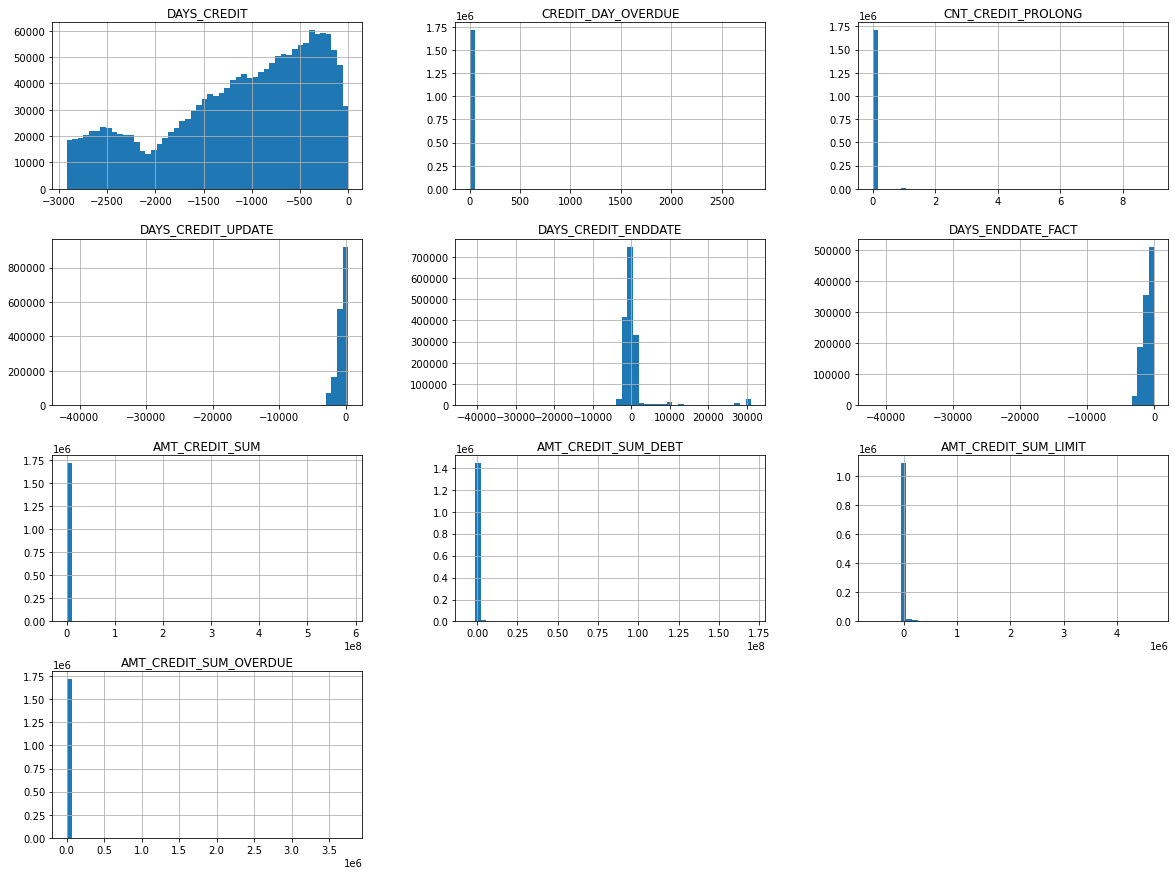

In [208]:
bureau[num_variables].hist(bins=50, figsize=(20,15))
plt.show()

Findings:

* "DAYS(...)" variables are counter-intuitively negative

In [209]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
day_variables = [col for col in bureau.columns if 'DAYS' in col]
num_variables = [i for i in num_variables if i not in day_variables]

#### Pipeline

Create a DataFrameSelector Class to be used later on the pipeline

In [210]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, y=None):
        return self
    
    def transform(self, bureau):
        return bureau[self.attribute_names].values
    
    def get_feature_names(self):
        return self.attribute_names

Create a NegativeToPositive Class to be used later on the pipeline

In [211]:
class NegativeToPositive(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, installment_payments, y=None):
        return self
    def transform(self, installment_payments):
        installment_payments[self.attribute_names] = abs(installment_payments[self.attribute_names])
        return installment_payments[self.attribute_names]

Create the pipeline for each of the features types

In [212]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median"))
        ])

day_col_pipeline = Pipeline([
        ('neg_to_pos', NegativeToPositive(day_variables)),
        ('imputer', SimpleImputer(strategy="median"))
        ])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", day_col_pipeline, day_variables),
        ("cat_pipeline", cat_pipeline, cat_variables)
])

Fit and transform the pipeline

In [213]:
preprocess_pipeline.fit(bureau)

preprocessed_bureau = preprocess_pipeline.transform(bureau)

In [214]:
#Get the name of the new categorical features generated by the pipeline
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(cat_variables))

#Get the name of all features
feature_names = num_variables + day_variables + cat_feature_names

Create a new dataframe with the features after being preprocessed

In [215]:
transformed_bureau_df = pd.DataFrame(preprocessed_bureau, columns=feature_names)
transformed_bureau_df = pd.concat([bureau[["SK_ID_CURR", "SK_ID_BUREAU"]],transformed_bureau_df], axis=1)
transformed_bureau_df

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,0.0,0.0,91323.00,0.0,0.0,0.0,497.0,153.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,215354,5714463,0.0,0.0,225000.00,171342.0,0.0,0.0,208.0,1075.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,215354,5714464,0.0,0.0,464323.50,0.0,0.0,0.0,203.0,528.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,215354,5714465,0.0,0.0,90000.00,0.0,0.0,0.0,203.0,862.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,215354,5714466,0.0,0.0,2700000.00,0.0,0.0,0.0,629.0,1197.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,0.0,0.0,11250.00,11250.0,0.0,0.0,44.0,30.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1716424,100044,5057754,0.0,0.0,38130.84,0.0,0.0,0.0,2648.0,2433.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1716425,100044,5057762,0.0,0.0,15570.00,0.0,0.0,0.0,1809.0,1628.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1716426,246829,5057770,0.0,0.0,36000.00,0.0,0.0,0.0,1878.0,1513.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Bureau + Bureau Balance 

Print bureau_balance dataframe

In [216]:
bureau_balance.head()

,SK_ID_BUREAU,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C
0,5001709,0.0,0.0,0.0,0.0,0.0,0.0,97.0
1,5001710,5.0,0.0,0.0,0.0,0.0,0.0,78.0
2,5001711,3.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5001712,10.0,0.0,0.0,0.0,0.0,0.0,9.0
4,5001713,0.0,0.0,0.0,0.0,0.0,0.0,22.0


Print bureau dataframe

In [217]:
transformed_bureau_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,0.0,0.0,91323.0,0.0,0.0,0.0,497.0,153.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,215354,5714463,0.0,0.0,225000.0,171342.0,0.0,0.0,208.0,1075.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,215354,5714464,0.0,0.0,464323.5,0.0,0.0,0.0,203.0,528.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,215354,5714465,0.0,0.0,90000.0,0.0,0.0,0.0,203.0,862.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,215354,5714466,0.0,0.0,2700000.0,0.0,0.0,0.0,629.0,1197.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Merge both dataframes on the SK_ID_BUREAU

In [218]:
bureau_merged = transformed_bureau_df.merge(bureau_balance, on="SK_ID_BUREAU", how="left")
bureau_merged

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,...,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C
0,215354,5714462,0.0,0.0,91323.00,0.0,0.0,0.0,497.0,153.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,0.0,0.0,225000.00,171342.0,0.0,0.0,208.0,1075.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,0.0,0.0,464323.50,0.0,0.0,0.0,203.0,528.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,0.0,0.0,90000.00,0.0,0.0,0.0,203.0,862.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,0.0,0.0,2700000.00,0.0,0.0,0.0,629.0,1197.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,0.0,0.0,11250.00,11250.0,0.0,0.0,44.0,30.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716424,100044,5057754,0.0,0.0,38130.84,0.0,0.0,0.0,2648.0,2433.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716425,100044,5057762,0.0,0.0,15570.00,0.0,0.0,0.0,1809.0,1628.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716426,246829,5057770,0.0,0.0,36000.00,0.0,0.0,0.0,1878.0,1513.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Perform groupby by SK_ID_CURR applying some appropriate aggregation functions for each feature

In [219]:
bureau_all = bureau_merged.groupby('SK_ID_CURR').agg(
    {'SK_ID_BUREAU': 'count',
    'CREDIT_DAY_OVERDUE': 'mean',
    'CNT_CREDIT_PROLONG': 'mean',
    'AMT_CREDIT_SUM': 'mean',
    'AMT_CREDIT_SUM_DEBT': 'mean',
    'AMT_CREDIT_SUM_LIMIT': 'mean',
    'AMT_CREDIT_SUM_OVERDUE': 'mean',
    'DAYS_CREDIT': 'mean',
    'DAYS_CREDIT_ENDDATE': 'mean',
    'DAYS_ENDDATE_FACT': 'mean',
    'DAYS_CREDIT_UPDATE': 'mean',
    'CREDIT_ACTIVE_Active': 'sum',
    'CREDIT_ACTIVE_Bad debt': 'sum',
    'CREDIT_ACTIVE_Closed': 'sum',
    'CREDIT_ACTIVE_Sold': 'sum',
    'CREDIT_CURRENCY_currency 1': 'sum',
    'CREDIT_CURRENCY_currency 2': 'sum',
    'CREDIT_CURRENCY_currency 3': 'sum',
    'CREDIT_CURRENCY_currency 4': 'sum',
    'CREDIT_TYPE_Another type of loan': 'sum',
    'CREDIT_TYPE_Car loan': 'sum',
    'CREDIT_TYPE_Cash loan (non-earmarked)': 'sum',
    'CREDIT_TYPE_Consumer credit': 'sum',
    'CREDIT_TYPE_Credit card': 'sum',
    'CREDIT_TYPE_Interbank credit': 'sum',
    'CREDIT_TYPE_Loan for business development': 'sum',
    'CREDIT_TYPE_Loan for purchase of shares (margin lending)': 'sum',
    'CREDIT_TYPE_Loan for the purchase of equipment': 'sum',
    'CREDIT_TYPE_Loan for working capital replenishment': 'sum',
    'CREDIT_TYPE_Microloan': 'sum',
    'CREDIT_TYPE_Mobile operator loan': 'sum',
    'CREDIT_TYPE_Mortgage': 'sum',
    'CREDIT_TYPE_Real estate loan': 'sum',
    'CREDIT_TYPE_Unknown type of loan': 'sum',
    'STATUS_0': 'sum',
    'STATUS_1': 'sum',
    'STATUS_2': 'sum',
    'STATUS_3': 'sum',
    'STATUS_4': 'sum',
    'STATUS_5': 'sum',
    'STATUS_C': 'sum',
    }).reset_index()

bureau_all

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,...,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C
0,100001,7,0.0,0.000000,2.076236e+05,85240.928571,0.000000,0.0,735.000000,800.714286,...,0.0,0.0,0.0,31.0,1.0,0.0,0.0,0.0,0.0,140.0
1,100002,8,0.0,0.000000,1.081319e+05,30722.625000,3998.570625,0.0,874.000000,709.000000,...,0.0,0.0,0.0,45.0,27.0,0.0,0.0,0.0,0.0,38.0
2,100003,4,0.0,0.000000,2.543501e+05,0.000000,202500.000000,0.0,1400.750000,1152.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,2,0.0,0.000000,9.451890e+04,0.000000,0.000000,0.0,867.000000,488.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100005,3,0.0,0.000000,2.190420e+05,189469.500000,0.000000,0.0,190.666667,524.666667,...,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,13,0.0,0.000000,2.841430e+05,12543.923077,0.000000,0.0,1667.076923,1413.538462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
305807,456250,3,0.0,0.000000,1.028820e+06,744013.365000,19422.795000,0.0,862.000000,1469.666667,...,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,75.0
305808,456253,4,0.0,0.000000,9.900000e+05,448958.250000,0.000000,0.0,867.500000,469.500000,...,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,70.0
305809,456254,1,0.0,0.000000,4.500000e+04,0.000000,0.000000,0.0,1104.000000,859.000000,...,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,29.0


Rename all the exclusive features that belongs to the Bureau Table so later it becomes more clear while performing analysis

In [220]:
bureau_all.columns = ["SK_ID_CURR"] + [col + '_BU' for col in bureau_all.columns if col not in ["SK_ID_CURR"]]
bureau_all

,SK_ID_CURR,SK_ID_BUREAU_BU,CREDIT_DAY_OVERDUE_BU,CNT_CREDIT_PROLONG_BU,AMT_CREDIT_SUM_BU,AMT_CREDIT_SUM_DEBT_BU,AMT_CREDIT_SUM_LIMIT_BU,AMT_CREDIT_SUM_OVERDUE_BU,DAYS_CREDIT_BU,DAYS_CREDIT_ENDDATE_BU,...,CREDIT_TYPE_Mortgage_BU,CREDIT_TYPE_Real estate loan_BU,CREDIT_TYPE_Unknown type of loan_BU,STATUS_0_BU,STATUS_1_BU,STATUS_2_BU,STATUS_3_BU,STATUS_4_BU,STATUS_5_BU,STATUS_C_BU
0,100001,7,0.0,0.000000,2.076236e+05,85240.928571,0.000000,0.0,735.000000,800.714286,...,0.0,0.0,0.0,31.0,1.0,0.0,0.0,0.0,0.0,140.0
1,100002,8,0.0,0.000000,1.081319e+05,30722.625000,3998.570625,0.0,874.000000,709.000000,...,0.0,0.0,0.0,45.0,27.0,0.0,0.0,0.0,0.0,38.0
2,100003,4,0.0,0.000000,2.543501e+05,0.000000,202500.000000,0.0,1400.750000,1152.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,2,0.0,0.000000,9.451890e+04,0.000000,0.000000,0.0,867.000000,488.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100005,3,0.0,0.000000,2.190420e+05,189469.500000,0.000000,0.0,190.666667,524.666667,...,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,13,0.0,0.000000,2.841430e+05,12543.923077,0.000000,0.0,1667.076923,1413.538462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
305807,456250,3,0.0,0.000000,1.028820e+06,744013.365000,19422.795000,0.0,862.000000,1469.666667,...,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,75.0
305808,456253,4,0.0,0.000000,9.900000e+05,448958.250000,0.000000,0.0,867.500000,469.500000,...,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,70.0
305809,456254,1,0.0,0.000000,4.500000e+04,0.000000,0.000000,0.0,1104.000000,859.000000,...,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,29.0


## POSH_CASH_balance

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

In [222]:
posh = pd.read_csv('../all/POS_CASH_balance.csv')

In [223]:
posh.shape

(10001358, 8)

In [224]:
posh.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Split all feature into:
- Categorical
- Numerical
- Categorical Binary

In [225]:
variables_type = pd.DataFrame(posh.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in posh:
    if ((list(posh[i].unique()) == [0,1]) or (list(posh[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "SK_ID_PREV"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_STATUS']
Categorical variables (binary): []
Numerical variables: ['MONTHS_BALANCE', 'SK_DPD', 'SK_DPD_DEF', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']


In [226]:
for column in cat_variables:
    print(column)
    print(posh[column].unique())

NAME_CONTRACT_STATUS
['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'XNA' 'Amortized debt']


Contract status during the month.

In [227]:
#replace XNA for NaN
posh['NAME_CONTRACT_STATUS'] = posh['NAME_CONTRACT_STATUS'].replace('XNA', np.nan)

**Duplicates**

In [228]:
#check duplicates
duplicate_rows = posh[posh.duplicated()]
print('Number of duplicate rows:', len(duplicate_rows))

Number of duplicate rows: 0


**Missing Values**

In [229]:
#List the variables with missing values higher than 0% and lower than 40% to preprocess them later on
miss_lower40 = []
#List the variables with missing values higher or equal to 40% to exclude these variables later on
miss_higher40 = []

for i in posh:
    pct_missing = (posh[i].isna().sum()/len(posh[i]))*100
    if pct_missing > 0 and pct_missing < 40:
        miss_lower40.append(i)
    if pct_missing >= 40:
        miss_higher40.append(i)

In [230]:
#Exclude the variables with missing values higher or equal to 40%
if (len(miss_lower40) != 0) | (len(miss_higher40) != 0):
    cat_variables = [i for i in cat_variables if i not in miss_higher40]
    num_variables = [i for i in num_variables if i not in miss_higher40]

**Statistics**

In [231]:
posh[num_variables].describe()

,MONTHS_BALANCE,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06
mean,-3.501259e+01,1.160693e+01,6.544684e-01,1.708965e+01,1.048384e+01
std,2.606657e+01,1.327140e+02,3.276249e+01,1.199506e+01,1.110906e+01
min,-9.600000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,-5.400000e+01,0.000000e+00,0.000000e+00,1.000000e+01,3.000000e+00
50%,-2.800000e+01,0.000000e+00,0.000000e+00,1.200000e+01,7.000000e+00
75%,-1.300000e+01,0.000000e+00,0.000000e+00,2.400000e+01,1.400000e+01
max,-1.000000e+00,4.231000e+03,3.595000e+03,9.200000e+01,8.500000e+01


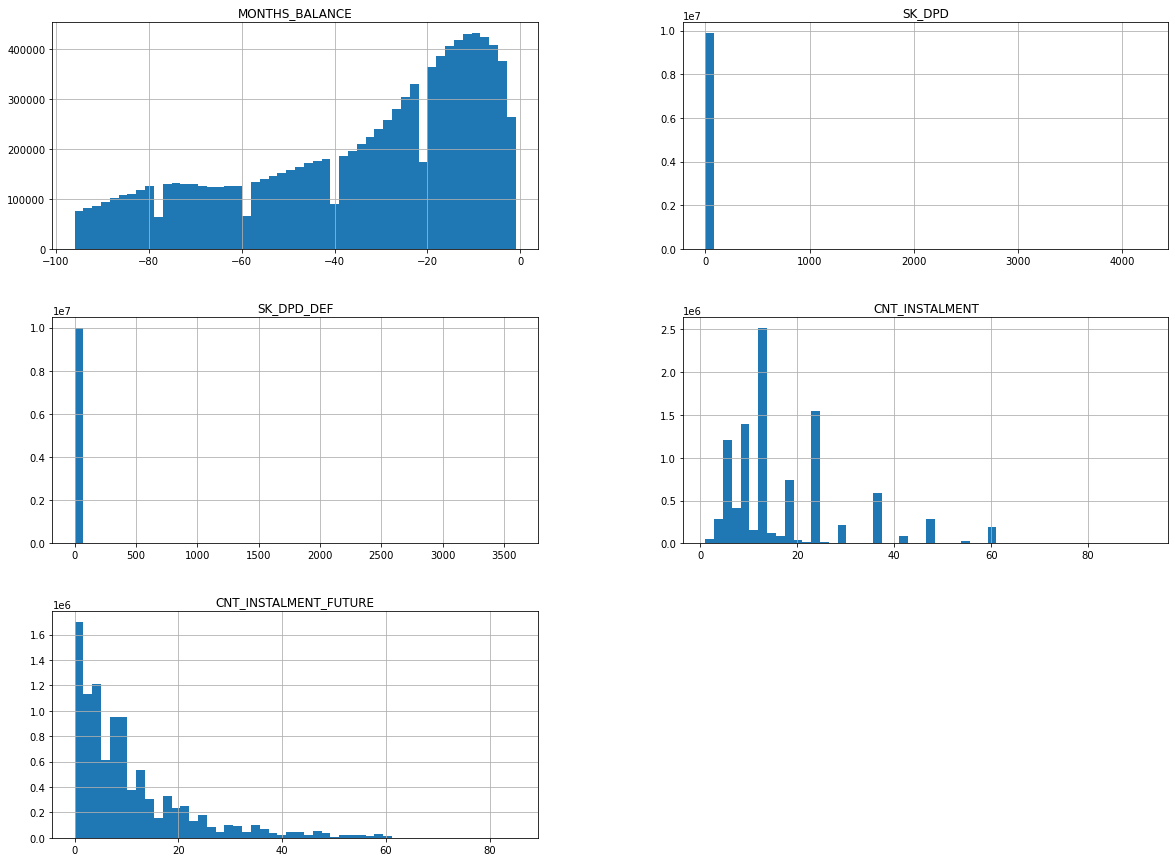

In [232]:
posh[num_variables].hist(bins=50, figsize=(20,15))
plt.show()

Findings:

* MONTHS_BALANCE - Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly)

* SK_DPD - DPD (days past due) during the month of previous credit

* SK_DPD_DEF - DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

* CNT_INSTALMENT - Term of previous credit (can change over time)

* CNT_INSTALMENT_FUTURE - Installments left to pay on the previous credit

MONTHS_BALANCE is not important.

In [233]:
posh = posh.drop('MONTHS_BALANCE', axis=1)

In [234]:
num_variables.remove('MONTHS_BALANCE')

### Pipeline

Create pipeline

In [235]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median"))
        ])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])

preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("cat_pipeline", cat_pipeline, cat_variables)
])

Fit and Transform the pipeline

In [236]:
preprocess_pipeline.fit(posh)

preprocessed_posh = preprocess_pipeline.transform(posh)

In [237]:
#Get the name of all categorical features after being preprocessed
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names_out(cat_variables))

#Get all the features after the pipeline
feature_names = num_variables + cat_feature_names

Create a dataframe with the features after the pipeline

In [238]:
transformed_posh_df = pd.DataFrame(preprocessed_posh, columns=feature_names)
transformed_posh_df = pd.concat([posh[["SK_ID_PREV", "SK_ID_CURR"]],transformed_posh_df], axis=1)
transformed_posh_df

,SK_ID_PREV,SK_ID_CURR,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed
0,1803195,182943,0.0,0.0,48.0,45.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1715348,367990,0.0,0.0,36.0,35.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1784872,397406,0.0,0.0,12.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1903291,269225,0.0,0.0,48.0,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2341044,334279,0.0,0.0,36.0,35.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,843.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001354,1717234,141565,602.0,0.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001355,1283126,315695,609.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001356,1082516,450255,614.0,0.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### GroupBy

Perform groupby by the SK_ID_CURR and use aggregation appropriate functions for each feature

In [239]:
posh_cash = transformed_posh_df.groupby('SK_ID_CURR').agg(
    {'SK_ID_PREV': 'count',
    'SK_DPD': 'mean', 
    'SK_DPD_DEF': 'mean', 
    'CNT_INSTALMENT': 'mean',
    'CNT_INSTALMENT_FUTURE': 'mean',
    'NAME_CONTRACT_STATUS_Active': 'sum', 
    'NAME_CONTRACT_STATUS_Amortized debt': 'sum',
    'NAME_CONTRACT_STATUS_Approved': 'sum', 
    'NAME_CONTRACT_STATUS_Canceled': 'sum',
    'NAME_CONTRACT_STATUS_Completed': 'sum', 
    'NAME_CONTRACT_STATUS_Demand': 'sum',
    'NAME_CONTRACT_STATUS_Returned to the store': 'sum',
    'NAME_CONTRACT_STATUS_Signed': 'sum'
    }).reset_index()

posh_cash.rename(columns = {'SK_ID_PREV':'COUNT_PREV'}, inplace = True)
posh_cash

,SK_ID_CURR,COUNT_PREV,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed
0,100001,9,0.777778,0.777778,4.000000,1.444444,7.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,100002,19,0.000000,0.000000,24.000000,15.000000,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,28,0.000000,0.000000,10.107143,5.785714,26.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,100004,4,0.000000,0.000000,3.750000,2.250000,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,100005,11,0.000000,0.000000,11.727273,7.181818,9.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,9,0.000000,0.000000,8.333333,4.666667,7.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
337248,456252,7,0.000000,0.000000,6.000000,3.000000,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
337249,456253,17,0.294118,0.294118,6.705882,2.000000,15.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
337250,456254,20,0.000000,0.000000,14.900000,10.350000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Rename all the exclusive features that belongs to the Posh Cash Table so later it becomes more clear while performing analysis

In [240]:
posh_cash.columns = ["SK_ID_CURR"] + [col + '_PC' for col in posh_cash.columns if col not in ["SK_ID_CURR"]]
posh_cash

,SK_ID_CURR,COUNT_PREV_PC,SK_DPD_PC,SK_DPD_DEF_PC,CNT_INSTALMENT_PC,CNT_INSTALMENT_FUTURE_PC,NAME_CONTRACT_STATUS_Active_PC,NAME_CONTRACT_STATUS_Amortized debt_PC,NAME_CONTRACT_STATUS_Approved_PC,NAME_CONTRACT_STATUS_Canceled_PC,NAME_CONTRACT_STATUS_Completed_PC,NAME_CONTRACT_STATUS_Demand_PC,NAME_CONTRACT_STATUS_Returned to the store_PC,NAME_CONTRACT_STATUS_Signed_PC
0,100001,9,0.777778,0.777778,4.000000,1.444444,7.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,100002,19,0.000000,0.000000,24.000000,15.000000,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,28,0.000000,0.000000,10.107143,5.785714,26.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,100004,4,0.000000,0.000000,3.750000,2.250000,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,100005,11,0.000000,0.000000,11.727273,7.181818,9.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,9,0.000000,0.000000,8.333333,4.666667,7.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
337248,456252,7,0.000000,0.000000,6.000000,3.000000,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
337249,456253,17,0.294118,0.294118,6.705882,2.000000,15.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
337250,456254,20,0.000000,0.000000,14.900000,10.350000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Merge all datasets

Merge all Datasets created in each of the sections before 1 by 1 to get a final data set to be used for the prediction phase

In [260]:
merge_1 = transformed_applications_df.merge(prev_applications, on="SK_ID_CURR", how="left")
merge_2 = merge_1.merge(credit_card_balance_grouped, on="SK_ID_CURR", how="left")
merge_3 = merge_2.merge(posh_cash, on="SK_ID_CURR", how="left")
merge_4 = merge_3.merge(bureau_all, on="SK_ID_CURR", how="left")
merge_5 = merge_4.merge(grouped_installment_payments, on="SK_ID_CURR", how="left")

merge_5["COUNT_PREV"] = merge_5[["COUNT_PREV_PA", "COUNT_PREV_CCB", "COUNT_PREV_PC", "COUNT_PREV_IP"]].max(axis=1)
merge_5.drop(columns=["COUNT_PREV_PA", "COUNT_PREV_CCB", "COUNT_PREV_PC", "COUNT_PREV_IP"], axis=1, inplace=True)

#Keeping only the columns that have a correlation with the TARGET higher than 0.01
correlation = pd.DataFrame(abs(merge_5.corrwith(merge_5["TARGET"])).sort_values(ascending=False))
columns_keep = list(correlation[correlation[0] > 0.01].index)
list_columns = ["SK_ID_CURR"]+columns_keep
table = merge_5[list_columns]

#Adding columns for each column if the value is NaN given that, since the imputer was done previously to each table, a NaN value indicates that there is no information about these ID in the other tables (should not be considered as a normal NaN value)
def preprocess_df(df):
    new_df = df.copy()
    if df.isnull().any().any():
        for col in df.columns:
            if df[col].isnull().values.any():
                new_df[col + '_AVAILABLE'] = np.where(df[col].isnull(), 0, 1)
                new_df[col] = new_df[col].fillna(0)
        return new_df
    return new_df

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
    table = preprocess_df(table)

Split features into:
- Categorical Binary
- Numerical

In [242]:
variables_type = pd.DataFrame(table.dtypes)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in table:
    if ((list(table[i].unique()) == [0,1]) or (list(table[i].unique()) == [1,0]) or (list(table[i].unique()) == [1.0,0.0]) or (list(table[i].unique()) == [0.0,1.0])) and i != "TARGET":
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR","TARGET"]]

float_with_no_binary = [i for i in float_variables if i not in cat_binary_variables and i not in ["SK_ID_CURR","TARGET"]]

num_variables = int_with_no_binary + float_with_no_binary

print(cat_binary_variables)
print(num_variables)

['NAME_INCOME_TYPE_Working_APP', 'NAME_EDUCATION_TYPE_Higher education_APP', 'CODE_GENDER_M_APP', 'CODE_GENDER_F_APP', 'REG_CITY_NOT_WORK_CITY_APP', 'REGION_RATING_CLIENT_W_CITY_3_APP', 'NAME_EDUCATION_TYPE_Secondary / secondary special_APP', 'REGION_RATING_CLIENT_3_APP', 'NAME_INCOME_TYPE_Pensioner_APP', 'FLAG_EMP_PHONE_APP', 'REG_CITY_NOT_LIVE_CITY_APP', 'FLAG_DOCUMENT_3_APP', 'REGION_RATING_CLIENT_W_CITY_1_APP', 'REGION_RATING_CLIENT_1_APP', 'LIVE_CITY_NOT_WORK_CITY_APP', 'NAME_CONTRACT_TYPE_Revolving loans_APP', 'NAME_CONTRACT_TYPE_Cash loans_APP', 'OCCUPATION_TYPE_Drivers_APP', 'NAME_HOUSING_TYPE_With parents_APP', 'ORGANIZATION_TYPE_Self-employed_APP', 'FLAG_DOCUMENT_6_APP', 'NAME_HOUSING_TYPE_House / apartment_APP', 'FLAG_WORK_PHONE_APP', 'OCCUPATION_TYPE_Low-skill Laborers_APP', 'NAME_FAMILY_STATUS_Single / not married_APP', 'NAME_FAMILY_STATUS_Married_APP', 'FLAG_PHONE_APP', 'NAME_INCOME_TYPE_State servant_APP', 'NAME_FAMILY_STATUS_Civil marriage_APP', 'FLAG_OWN_CAR_APP', 'OCC

Split data set into 20% test and 80% training

In [243]:
X = table.drop(["SK_ID_CURR", "TARGET"], axis=1)
y = table["TARGET"].apply(lambda x: 0 if x == 1 else 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create the pipeline, fit and transform

In [244]:
num_pipeline = Pipeline([("std_scaler", StandardScaler())])
num_preprocessor = ColumnTransformer([('num_pipeline', num_pipeline, num_variables)])

X_train_num_preprocessed = num_preprocessor.fit_transform(X_train)
X_test_num_preprocessed = num_preprocessor.transform(X_test)

Create a DataFrameSelector Class to be used in the pipeline

In [245]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names, df=X_train):
        self.attribute_names = attribute_names
        self.df = df
    
    def fit(self, y=None):
        return self
    
    def transform(self, df):
        return self.df[self.attribute_names].values
    
    def get_feature_names(self):
        return self.attribute_name

Create more pipelines, fit and transform them

In [246]:
binary_pipeline_train = Pipeline([("selector", DataFrameSelector(cat_binary_variables, X_train))])
binary_preprocessor_train = ColumnTransformer([('cat_binary_pipeline', binary_pipeline_train, cat_binary_variables)])

X_train_bin_preprocessed = binary_preprocessor_train.fit_transform(X_train)

binary_pipeline_test = Pipeline([("selector", DataFrameSelector(cat_binary_variables, X_test))])
binary_preprocessor_test = ColumnTransformer([('cat_binary_pipeline', binary_pipeline_test, cat_binary_variables)])

X_test_bin_preprocessed = binary_preprocessor_test.fit_transform(X_test)

In [247]:
#Merge train numericals and binaries preprocesseds
X_train_preprocessed = np.c_[X_train_num_preprocessed, X_train_bin_preprocessed]

#Merge test numericals and binaries preprocesseds
X_test_preprocessed = np.c_[X_test_num_preprocessed, X_test_bin_preprocessed]

Get the final dataframe after the pipelines

In [248]:
feature_names = num_variables + cat_binary_variables
X_train_finaldf = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_train_finaldf

,EXT_SOURCE_2_APP,EXT_SOURCE_3_APP,DAYS_CREDIT_BU,AMT_BALANCE_CCB,AMT_TOTAL_RECEIVABLE_CCB,CNT_DRAWINGS_CURRENT_CCB,DAYS_BIRTH_APP,DAYS_CREDIT_UPDATE_BU,CREDIT_ACTIVE_Active_BU,NAME_CONTRACT_STATUS_Refused_PA,...,WEEKDAY_APPR_PROCESS_START_TUESDAY_PA_AVAILABLE,NAME_CONTRACT_STATUS_Sent proposal_CCB_AVAILABLE,WEEKDAY_APPR_PROCESS_START_FRIDAY_PA_AVAILABLE,CREDIT_ACTIVE_Sold_BU_AVAILABLE,PRODUCT_COMBINATION_POS household with interest_PA_AVAILABLE,CODE_REJECT_REASON_XAP_PA_AVAILABLE,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_PA_AVAILABLE,AMT_CREDIT_SUM_LIMIT_BU_AVAILABLE,CREDIT_TYPE_Consumer credit_BU_AVAILABLE,STATUS_4_BU_AVAILABLE
0,-0.816960,0.274694,0.781601,1.038222,1.047846,-0.103786,1.676136,0.426087,1.238841,-0.450319,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-0.126744,0.455694,0.731792,-0.305360,-0.305127,-0.209717,-1.173499,0.175085,1.238841,0.114535,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.675401,1.089622,0.630922,-0.305360,-0.305127,-0.209717,1.644952,0.736387,-0.976672,0.679390,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,-0.461405,-0.053583,-0.180263,-0.305360,-0.305127,-0.209717,-1.223484,0.102225,0.684963,1.244245,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,-0.360440,0.070105,-0.035208,0.127002,0.129468,-0.188889,-0.055244,0.237575,1.238841,-0.450319,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,0.538003,0.111223,-1.439801,-0.305360,-0.305127,-0.209717,-0.357221,-1.016373,-0.976672,-0.450319,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
246004,1.089278,-0.831101,0.069317,-0.305360,-0.305127,-0.209717,-0.125407,0.234862,0.131085,0.679390,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
246005,0.492143,0.223817,0.342750,-0.305360,-0.305127,-0.209717,-0.396659,0.226495,1.238841,-0.450319,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
246006,0.437299,-1.467508,-0.339475,0.646980,0.649548,1.000922,-0.764213,-0.967007,1.238841,-0.450319,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Perform a RandomForestClassifier using grid_search to help us finding the best hyperparameters for the n_estimators and max_depth using the precision as the decicion score

In [249]:
# create a random forest classifier
rfc = RandomForestClassifier()

# define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 15, 20],
    'max_depth': [10, 15, 20],
}

# perform grid search cross-validation
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='precision')
grid_search.fit(X_train_preprocessed, y_train)

# print the best hyperparameters and corresponding accuracy score
print('Best hyperparameters:', grid_search.best_params_)
y_pred = grid_search.predict(X_test_preprocessed)
print('Precision:', precision_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

Best hyperparameters: {'max_depth': 20, 'n_estimators': 10}
Precision: 0.9203679840801213
Accuracy: 0.9185242996276605
Recall: 0.9977189942355978


Create a Confusion Matrix

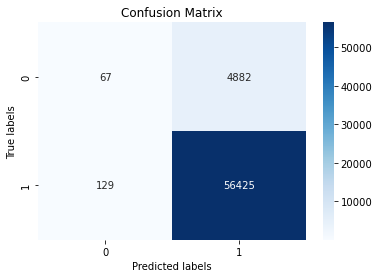

In [252]:
confusion = confusion_matrix(y_test, y_pred)

TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]

sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

plt.title("Confusion Matrix")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()